# 2. U-Net Model Training for Building Segmentation

This notebook focuses on building, training, and evaluating the U-Net model for our building segmentation task.

**Workflow:**
1.  Load the preprocessed data from the `.npy` files.
2.  Define the U-Net model architecture.
3.  Compile and train the model.
4.  Evaluate the model's performance and visualize the results.

In [19]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image

from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Dropout

%matplotlib inline

## 2.1. Load Preprocessed Data

We'll load the NumPy arrays that were created in the previous notebook.

In [20]:
PROCESSED_DATA_PATH = '../data/processed/'

X_train = np.load(os.path.join(PROCESSED_DATA_PATH, 'X_train.npy'))
Y_train = np.load(os.path.join(PROCESSED_DATA_PATH, 'Y_train.npy'))

X_test = np.load(os.path.join(PROCESSED_DATA_PATH, 'X_test.npy'))
Y_test = np.load(os.path.join(PROCESSED_DATA_PATH, 'Y_test.npy'))

print("Data loaded successfully.")
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)

Data loaded successfully.
X_train shape: (70, 128, 128, 3)
Y_train shape: (70, 128, 128, 1)


## 2.2. Build the U-Net Model

Here, we define the U-Net architecture. The model consists of an encoder (down-sampling path) to capture context and a decoder (up-sampling path) to enable precise localization. Skip connections are used to merge feature maps from the encoder to the decoder.

In [21]:
def build_unet_model_v2(input_shape):
    """
    Builds a more robust U-Net model architecture with more filters.
    """
    inputs = Input(input_shape)

    # Encoder Path
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.3)(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)

    # Decoder Path
    u4 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = Concatenate()([u4, c2])
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u4)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)

    u5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = Concatenate()([u5, c1])
    c5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Output Layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Build the new model
input_shape = (128, 128, 3)
model = build_unet_model_v2(input_shape)

# Compile the model
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2, name='mean_iou')]
)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 128, 128, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 128, 128, 64) 0           conv2d_22[0][0]                  
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 128, 128, 64) 36928       dropout_10[0][0]                 
____________________________________________________________________________________________

## 2.3. Train the Model

Now we train the model using the preprocessed training data (`X_train`, `Y_train`) and validate it on the test data.

In [22]:
# Define callbacks
MODEL_SAVE_PATH = '../saved_models/unet_building_segmentation_v2.h5'
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', mode='min', verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath=MODEL_SAVE_PATH, save_best_only=True, monitor='val_loss', mode='min', verbose=1)
]

# Train the model for more epochs to allow for better learning
history = model.fit(
    X_train,
    Y_train,
    batch_size=16,
    epochs=50,  # Increased epochs
    validation_data=(X_test, Y_test),
    callbacks=callbacks
)

Epoch 1/50
5/5 [==============================] - 10s 2s/step - loss: 15.5417 - accuracy: 0.6278 - mean_iou: 0.3963 - val_loss: 1.8143 - val_accuracy: 0.7631 - val_mean_iou: 0.4057

Epoch 1: val_loss improved from inf to 1.81433, saving model to ../saved_models\unet_building_segmentation_v2.h5
Epoch 2/50
5/5 [==============================] - 15s 3s/step - loss: 2.4458 - accuracy: 0.6717 - mean_iou: 0.4053 - val_loss: 0.8605 - val_accuracy: 0.7694 - val_mean_iou: 0.4026

Epoch 2: val_loss improved from 1.81433 to 0.86055, saving model to ../saved_models\unet_building_segmentation_v2.h5
Epoch 3/50
5/5 [==============================] - 16s 3s/step - loss: 1.3787 - accuracy: 0.7078 - mean_iou: 0.4011 - val_loss: 0.6074 - val_accuracy: 0.8065 - val_mean_iou: 0.3997

Epoch 3: val_loss improved from 0.86055 to 0.60736, saving model to ../saved_models\unet_building_segmentation_v2.h5
Epoch 4/50
5/5 [==============================] - 22s 5s/step - loss: 1.0081 - accuracy: 0.7372 - mean_iou: 0

## 2.4. Evaluate Model Performance

Let's plot the training and validation accuracy and loss to visualize the model's performance over epochs.

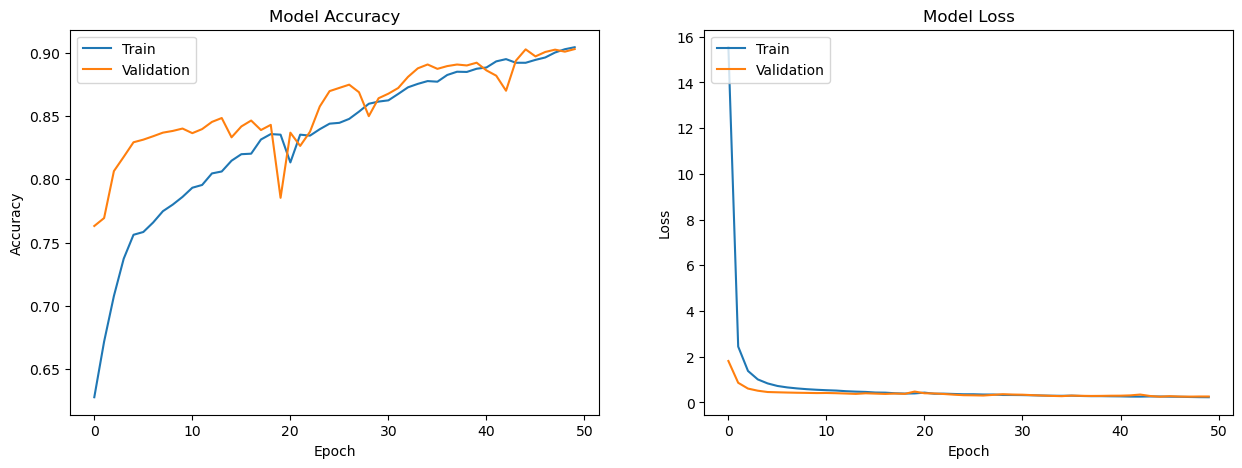

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot training & validation accuracy values
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

## 2.5. Visualize Predictions

Finally, let's load our best saved model and use it to make predictions on the test set. We will visualize a few examples to see how well our model performs.

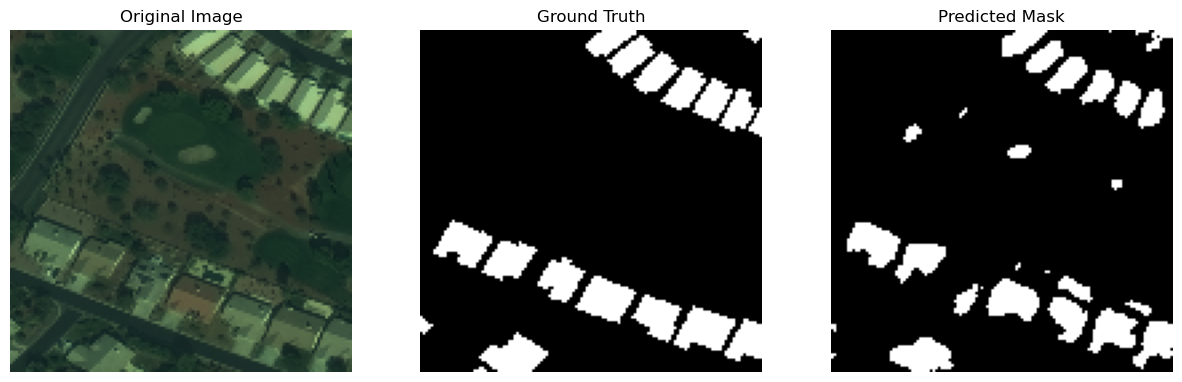

In [24]:
# Load the best model saved by our callback
model.load_weights(MODEL_SAVE_PATH)

# Make predictions on the test set
preds_test = model.predict(X_test)

# Apply a threshold to get binary masks
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Visualize a few random predictions
ix = np.random.randint(0, len(X_test))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Original Image
ax[0].imshow(X_test[ix])
ax[0].set_title('Original Image')
ax[0].axis('off')

# Ground Truth Mask
ax[1].imshow(np.squeeze(Y_test[ix]), cmap='gray')
ax[1].set_title('Ground Truth')
ax[1].axis('off')

# Predicted Mask
ax[2].imshow(np.squeeze(preds_test_t[ix]), cmap='gray')
ax[2].set_title('Predicted Mask')
ax[2].axis('off')

plt.show()

In [25]:
# --- Save a few prediction examples to the results folder ---

# Create the results directory if it doesn't exist
RESULTS_PATH = '../results/'
os.makedirs(RESULTS_PATH, exist_ok=True)

# Save the first 6 examples (Original, Ground Truth, Predicted)
num_examples_to_save = 6
for i in range(num_examples_to_save):
    # 1. Save the Original Image
    original_img = Image.fromarray(X_test[i])
    original_img.save(os.path.join(RESULTS_PATH, f'example_{i}_original.png'))

    # 2. Save the Ground Truth Mask
    ground_truth_mask = Image.fromarray(Y_test[i].squeeze().astype(np.uint8) * 255)
    ground_truth_mask.save(os.path.join(RESULTS_PATH, f'example_{i}_ground_truth.png'))

    # 3. Save the Predicted Mask
    predicted_mask = Image.fromarray(preds_test_t[i].squeeze().astype(np.uint8) * 255)
    predicted_mask.save(os.path.join(RESULTS_PATH, f'example_{i}_predicted.png'))

print(f"{num_examples_to_save} full examples (Original, Ground Truth, Predicted) saved to the '{RESULTS_PATH}' folder.")

6 full examples (Original, Ground Truth, Predicted) saved to the '../results/' folder.
